In [40]:
import omnipath as op
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pySankey import sankey as sn
import mellon as ml
import networkx as nx
from matplotlib.pyplot import figure
import netrd
import itertools
import glob

In this analysis I have aimed to verify whether the LR network genes have any changes in the context of PD. I have found that: 

- LRs and DEGs have substantial overlap (up to 14% of the network were DEGs)
- Most of these are up-regulation events, not down-regulation
- these overlaps become more enriched as the network becomes more stringent
- Glia were the cell types with most DELRs
- LRs were only differentially expressed in the ACG (more severe disease), not in the IPL
- The cell types affected in PD and PDD were **distinct**

I may repeat this analysis with the dUTR results, since changes to splicing would also be disruptive to the LR network. 

As to LR pairs which may be interesting to assess, APOE and LDLR may be especially interesting to evaluate, since they are both differentially expressed in PD by different cell types (Astrocyte and inhibitory neuron, respectively). 17 LR PAIRS in the 0.4 network were DEGs (!)

In [51]:
tgts_all = pd.read_csv('/Users/melis/Documents/GitHub/LR_project/processed_data/hot-encoded-diseases_0.400000.csv', index_col = 0)

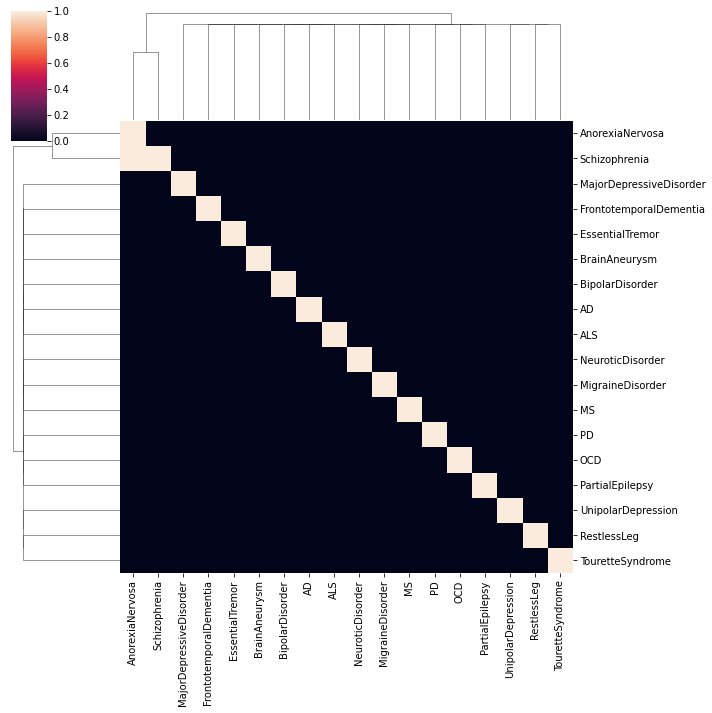

In [52]:
# Initialize an empty DataFrame for overlap percentages
overlap_matrix = pd.DataFrame(index=tgts_all.columns, columns=tgts_all.columns, dtype=float)
total_rows = len(tgts_all)
# Calculate % overlap for each column pair
for col1 in tgts_all.columns:
    for col2 in tgts_all.columns:
        overlap_count = ((tgts_all[col1] == 1) & (tgts_all[col2] == 1)).sum()
        overlap_matrix.loc[col1, col2] = (overlap_count / tgts_all[col2].sum()) * 100
sns.clustermap(overlap_matrix>95)

In [45]:
overlap_matrix

,AD,ALS,AnorexiaNervosa,BipolarDisorder,BrainAneurysm,EssentialTremor,FrontotemporalDementia,IntracranialHemorrhage,LBD,MajorDepressiveDisorder,...,Narcolepsy,NeuroticDisorder,OCD,PartialEpilepsy,PD,ProgressiveSupranuclearPalsy,RestlessLeg,Schizophrenia,TouretteSyndrome,UnipolarDepression
AD,100.000000,3.571429,1.265823,1.953125,1.298701,0.000000,25.714286,9.523810,28.571429,1.904762,...,9.523810,4.819277,0.520833,6.756757,8.550186,4.761905,0.000000,2.469136,0.476190,1.081081
ALS,1.680672,100.000000,0.843882,0.781250,2.597403,7.317073,48.571429,0.000000,0.000000,0.952381,...,4.761905,0.000000,0.520833,1.351351,1.115242,4.761905,0.000000,1.028807,0.476190,1.081081
AnorexiaNervosa,1.260504,1.785714,100.000000,39.453125,16.883117,0.000000,5.714286,0.000000,0.000000,29.523810,...,0.000000,15.662651,94.270833,4.054054,3.345725,0.000000,2.564103,22.839506,90.000000,36.396396
BipolarDisorder,4.201681,3.571429,85.232068,100.000000,16.883117,4.878049,11.428571,4.761905,0.000000,53.333333,...,9.523810,31.325301,94.791667,10.810811,4.832714,0.000000,7.692308,33.847737,92.380952,50.630631
BrainAneurysm,0.420168,1.785714,5.485232,2.539062,100.000000,0.000000,0.000000,0.000000,0.000000,3.809524,...,0.000000,1.204819,4.687500,0.000000,0.000000,0.000000,0.000000,1.543210,4.285714,1.981982
EssentialTremor,0.000000,2.678571,0.000000,0.390625,0.000000,100.000000,2.857143,0.000000,7.142857,0.000000,...,0.000000,1.204819,0.000000,4.054054,1.858736,0.000000,0.000000,0.823045,0.476190,0.720721
FrontotemporalDementia,3.781513,15.178571,0.843882,0.781250,0.000000,2.439024,100.000000,0.000000,0.000000,1.904762,...,0.000000,2.409639,0.520833,1.351351,2.230483,4.761905,0.000000,0.514403,0.476190,0.720721
IntracranialHemorrhage,0.840336,0.000000,0.000000,0.195312,0.000000,0.000000,0.000000,100.000000,7.142857,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.371747,0.000000,0.000000,0.000000,0.000000,0.000000
LBD,1.680672,0.000000,0.000000,0.000000,0.000000,2.439024,0.000000,4.761905,100.000000,0.000000,...,0.000000,1.204819,0.000000,1.351351,4.089219,0.000000,0.000000,0.000000,0.000000,0.000000
MajorDepressiveDisorder,0.840336,0.892857,13.080169,10.937500,5.194805,0.000000,5.714286,0.000000,0.000000,100.000000,...,0.000000,14.457831,15.104167,1.351351,1.858736,0.000000,2.564103,6.584362,13.809524,14.414414


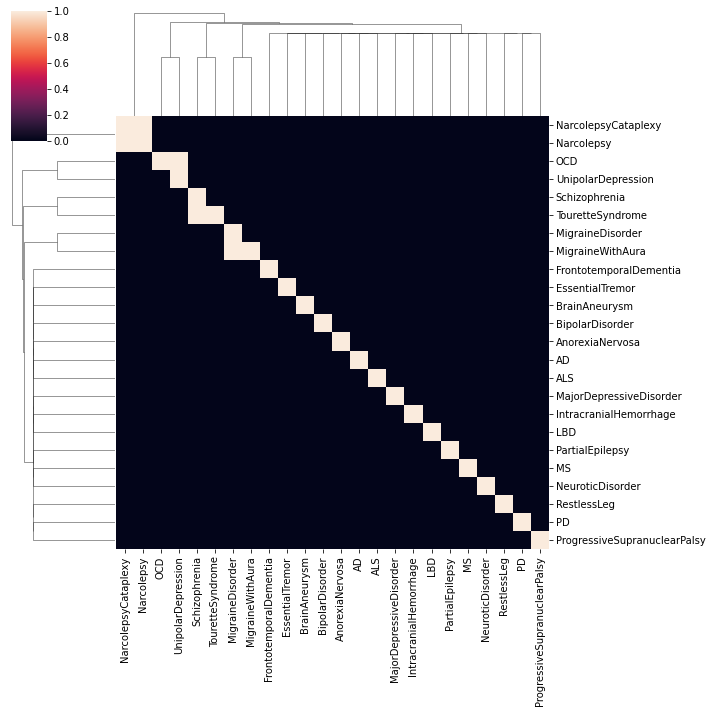

In [46]:
# Initialize an empty DataFrame for overlap percentages
overlap_matrix = pd.DataFrame(index=tgts_all.columns, columns=tgts_all.columns, dtype=float)
total_rows = len(tgts_all)
# Calculate % overlap for each column pair
for col1 in tgts_all.columns:
    for col2 in tgts_all.columns:
        overlap_count = ((tgts_all[col1] == 1) & (tgts_all[col2] == 1)).sum()
        overlap_matrix.loc[col1, col2] = (overlap_count / tgts_all[col1].sum()) * 100
sns.clustermap(overlap_matrix>95)

In [41]:
db = op.interactions.import_intercell_network(transmitter_params = {"categories":"ligand"}, receiver_params = {"categories": "receptor"})
db = db[np.logical_not(db['genesymbol_intercell_source'].str.startswith('HLA'))]
db = db[np.logical_not(db['genesymbol_intercell_target'].str.startswith('HLA'))]
db = db[~db['genesymbol_intercell_target'].astype(str).str.startswith('COMPLEX')]
db = db[~db['genesymbol_intercell_source'].astype(str).str.startswith('COMPLEX')]

In [ ]:
DEGs_list = ['CCK',
 'SMO',
 'ITGA4',
 'SDC3',
 'PLCG1',
 'CEACAM19',
 'EFNB1',
 'THBS2',
 'CCK',
 'CEACAM19',
 'BMP2',
 'TUBA4A',
 'PLAUR',
 'SMO',
 'LGALS1',
 'NRXN2',
 'SDC3',
 'ATP2B1',
 'PLCG1',
 'EFNB1',
 'CEACAM19',
 'CEACAM19',
 'THBS2',
 'CCK',
 'SMO',
 'LDLR',
 'CEACAM19',
 'LGALS1',
 'CNTNAP1',
 'BMP2',
 'SDC3',
 'SMO',
 'EDN1',
 'TUBA4A',
 'PTPN11',
 'SEMA3F',
 'PILRA',
 'PLAUR',
 'CEACAM19',
 'LGALS1',
 'NRXN2',
 'KITLG',
 'TXK',
 'ATP2B1',
 'WNT7B',
 'EFNB1',
 'TNK2',
 'NOS2',
 'CNTN6',
 'BMP6',
 'NPTX1',
 'APOD',
 'MAP2K5',
 'APOE',
 'CILK1',
 'CXCL14',
 'ITGB4',
 'PILRA',
 'PPARA',
 'CEACAM19',
 'CALCRL',
 'SMO',
 'SDC3',
 'FZD8',
 'NECTIN3',
 'CCN1',
 'CLEC2D',
 'CALCRL',
 'PLXNA1',
 'NLGN4X',
 'CEACAM19',
 'THBS2',
 'ITGA11',
 'CCK',
 'LGALS1',
 'NOS2',
 'CEACAM19',
 'SMO',
 'PILRA',
 'KITLG',
 'LDLR',
 'PILRA',
 'SMO',
 'CEACAM19',
 'NXPH1',
 'CNTNAP1',
 'CRHR1',
 'CEACAM19',
 'BMP2',
 'SDC3',
 'CEACAM19',
 'TUBA4A',
 'PTPN11',
 'SEMA3F',
 'JAG1',
 'PLAUR',
 'PILRA',
 'PTPRJ',
 'CEACAM19',
 'LGALS1',
 'PILRA',
 'PILRA',
 'ETV5',
 'NRXN2',
 'ATP2B1',
 'WNT7B',
 'BMP8B',
 'EFNB1',
 'TNK2',
 'NPTX1',
 'APOD',
 'LDLR',
 'MAP2K5',
 'ESR2',
 'NOX4',
 'CILK1',
 'APOE',
 'CALCRL',
 'CEACAM19',
 'CILK1',
 'CXCL14',
 'ITGB4',
 'PPARA',
 'CEACAM19',
 'SDC3',
 'FZD8',
 'NECTIN3',
 'CCN1',
 'VEGFA',
 'LDLR',
 'TSHR',
 'TGFB3',
 'CALR',
 'EDA',
 'INHBA']




,genesymbol_intercell_source,genesymbol_intercell_target
7,KITLG,JAK2
13,PTPN11,JAK2
34,EDN1,JAK2
43,KITLG,EPO
58,KITLG,PIK3R1
...,...,...
9621,CD99,PILRA
9622,MXRA5,PILRA
9670,FSTL5,CEACAM19
9685,PILRA,LILRB5


In [44]:
path = ["processed_data/hot-encoded-diseases_0.400000.csv", "processed_data/hot-encoded-diseases_0.700000.csv"]

for res in range(0,2):
    db = op.interactions.import_intercell_network(transmitter_params = {"categories":"ligand"}, receiver_params = {"categories": "receptor"})
    print(np.shape(db))
    db = db[np.logical_not(db['genesymbol_intercell_source'].str.startswith('HLA'))]
    db = db[np.logical_not(db['genesymbol_intercell_target'].str.startswith('HLA'))]
    db = db[~db['genesymbol_intercell_target'].astype(str).str.startswith('COMPLEX')]
    db = db[~db['genesymbol_intercell_source'].astype(str).str.startswith('COMPLEX')]
    print(np.shape(db))
    tgts_all = pd.read_csv(path[res])
    print(path[res])
    tgts_all['gene']=tgts_all['genes']
    tgts = tgts_all.drop(columns=['genes']).set_index(['gene'])

    source, percSrc, targets, percTgt, sum = ml.lr.find_hits(tgts, db)


    LRs = db[['genesymbol_intercell_source','genesymbol_intercell_target']][(db['genesymbol_intercell_source'].isin(list(sum.gene))) | (db['genesymbol_intercell_target'].isin(list(sum.gene)))]
    if res == 0:
        all_genes = np.unique(list(LRs['genesymbol_intercell_source'])+list(LRs['genesymbol_intercell_target']))
        df = pd.DataFrame(pd.DataFrame(all_genes).isin(np.unique(list(LRs['genesymbol_intercell_source'])+list(LRs['genesymbol_intercell_target'])))).rename(columns = {0:path[res].split('_')[2].split('.csv')[0]})
        df['genes'] = all_genes
        df.set_index('genes', inplace = True)
    else:
        df2 = pd.DataFrame(pd.DataFrame(all_genes).isin(np.unique(list(LRs['genesymbol_intercell_source'])+list(LRs['genesymbol_intercell_target'])))).rename(columns = {0:path[res].split('_')[2].split('.csv')[0]})
        df2['genes'] = all_genes
        df2.set_index('genes', inplace = True)
        df = df.merge(df2, left_index = True, right_index = True, how = 'left')

(9708, 45)
(8345, 45)
processed_data/hot-encoded-diseases_0.400000.csv
(9708, 45)
(8345, 45)
processed_data/hot-encoded-diseases_0.700000.csv


In [59]:
db[['genesymbol_intercell_source','genesymbol_intercell_target']][(db['genesymbol_intercell_source'].isin(list(sum.gene))) | (db['genesymbol_intercell_target'].isin(list(sum.gene)))]

,genesymbol_intercell_source,genesymbol_intercell_target
289,SNCA,SRC
523,FYN,GRIN2A
524,BDNF,GRIN2A
525,ANXA1,GRIN2A
526,IL16,GRIN2A
...,...,...
9550,SLURP2,CHRNB2
9604,CNTN2,CNTNAP2
9611,CNTN4,APLP1
9655,LGI1,ADAM23


(9708, 45)
(8345, 45)
0.400000.csv
STAT3    66.0
CXCR4    51.0
ITGB5    34.0
ITGA9    30.0
ITGA8    25.0
         ... 
ETV5      0.0
NMB       0.0
NLGN1     0.0
NID1      0.0
NGF       0.0
Length: 175, dtype: float64


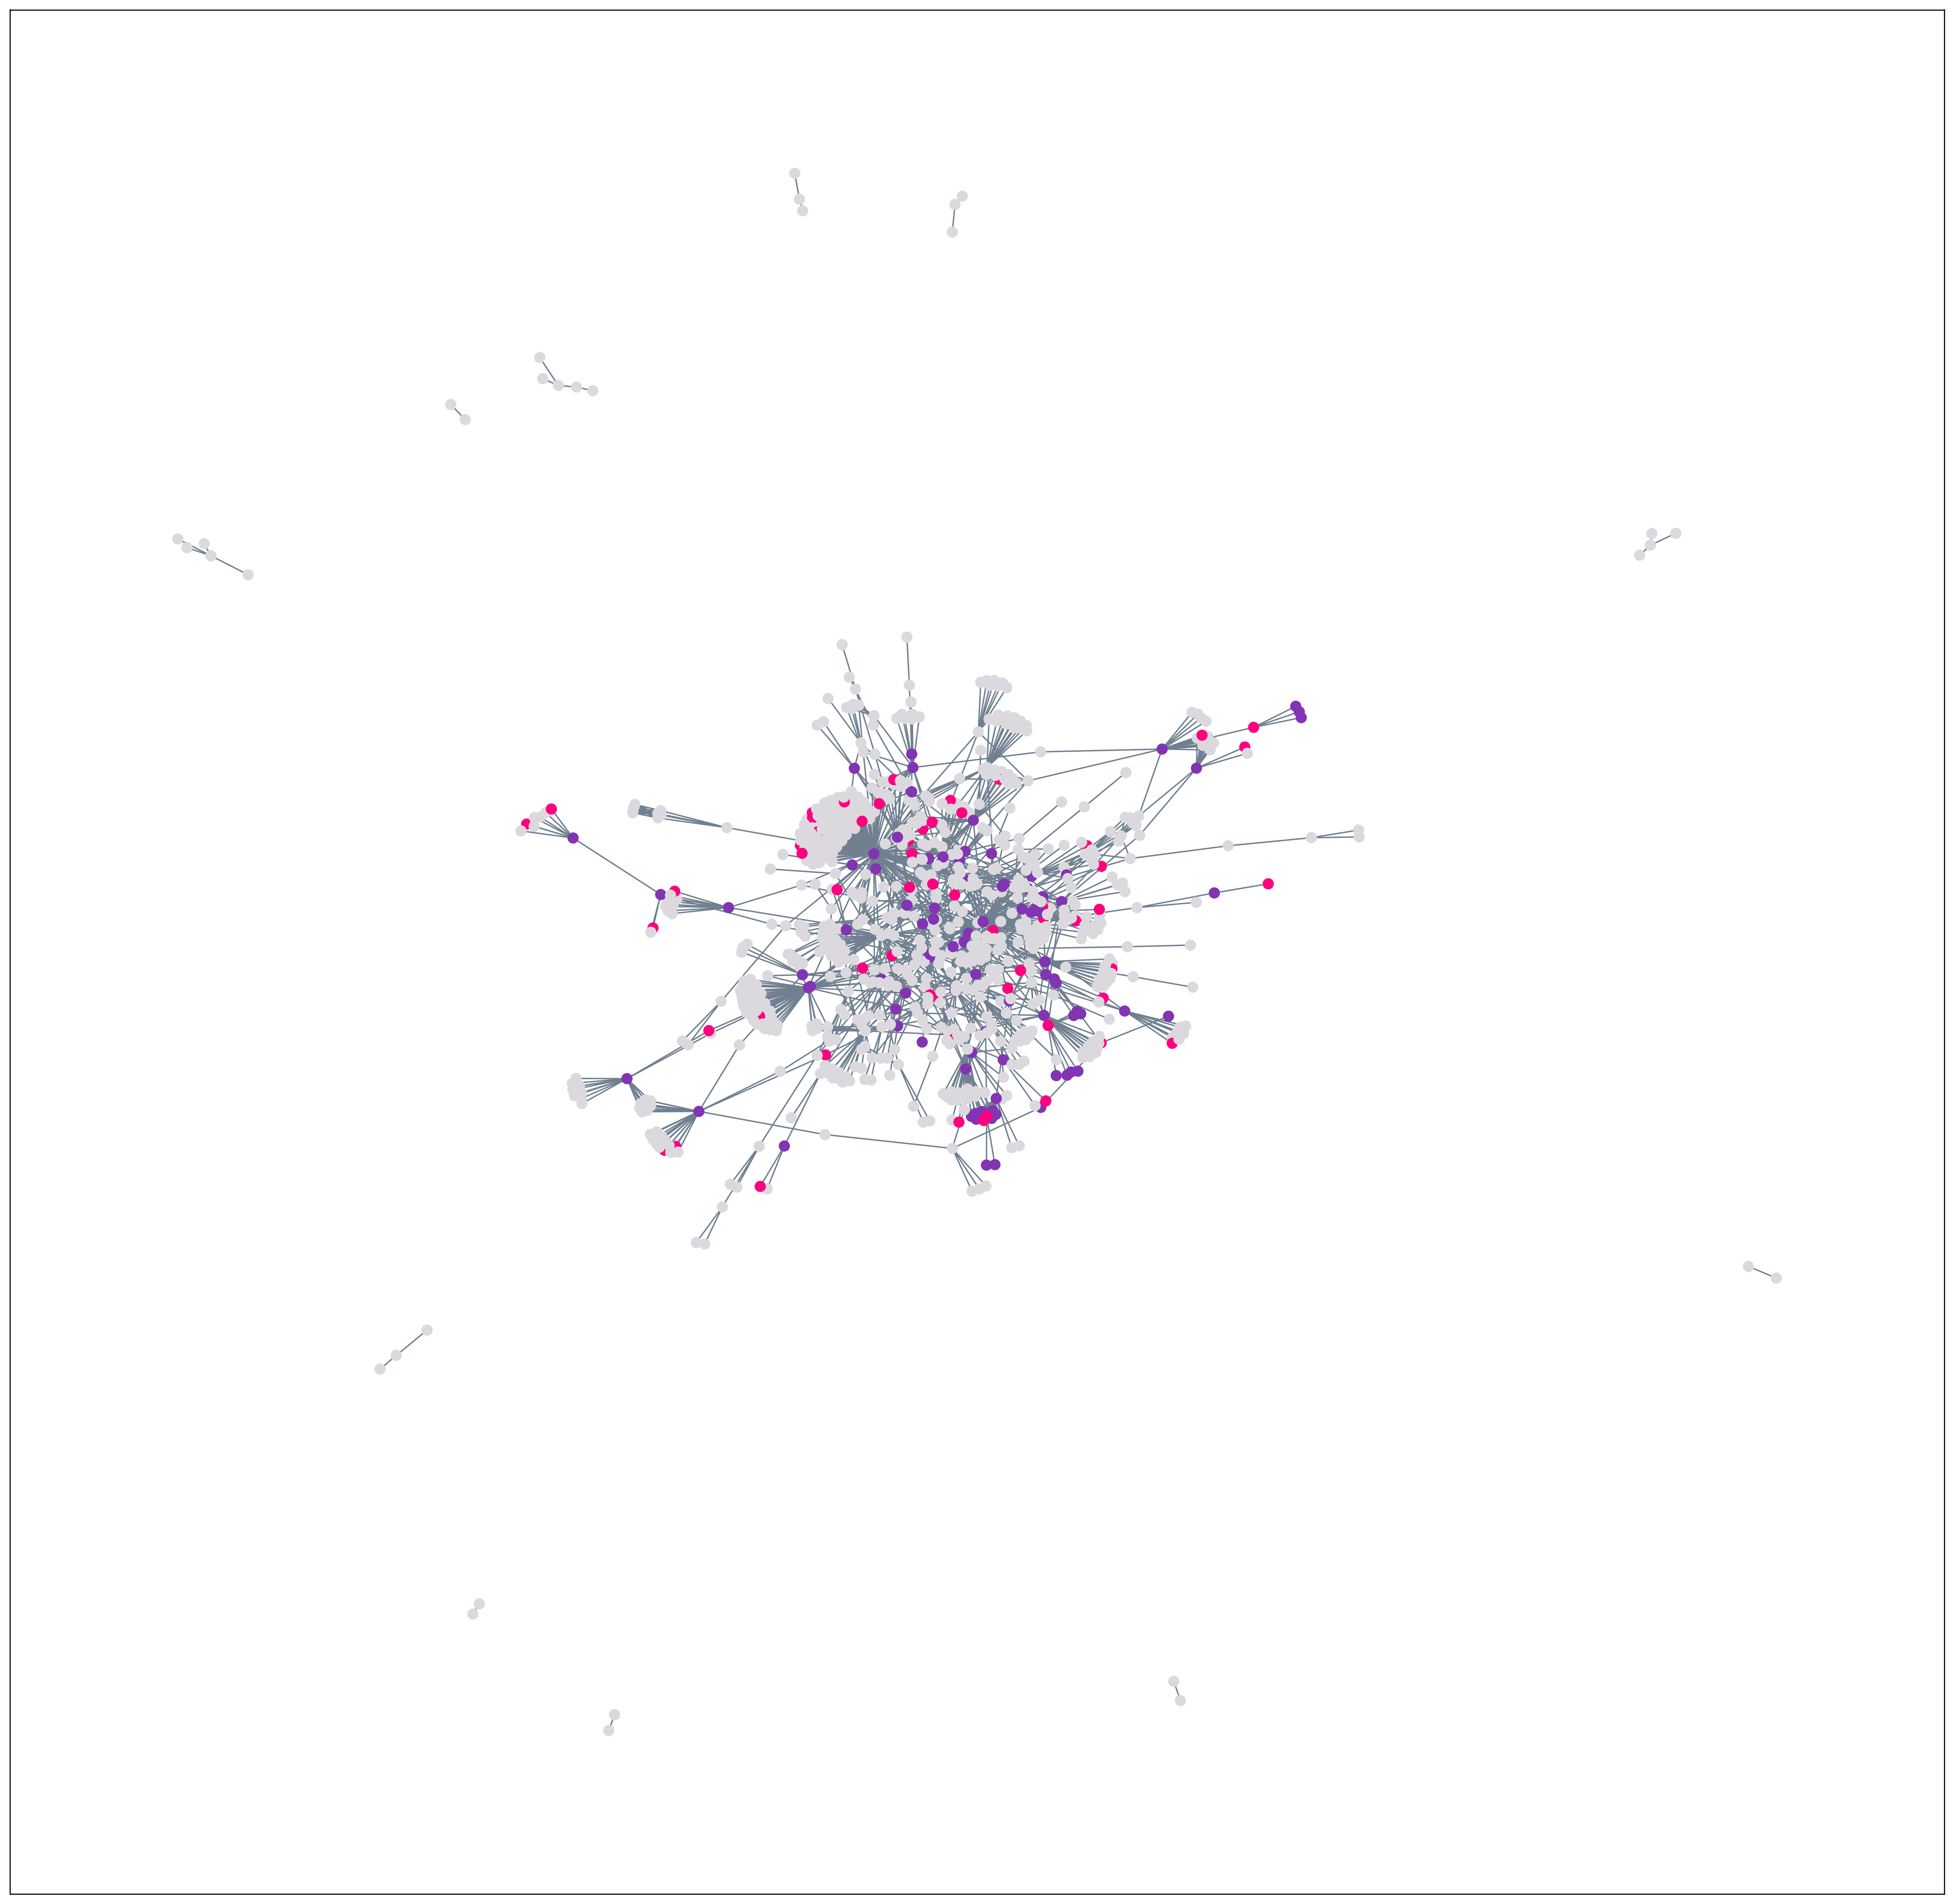

             0
AATK   #dcd9de
ABCB1  #dcd9de
ABL1   #dcd9de
ACE    #dcd9de
ACTR2  #dcd9de
...        ...
XCL2   #dcd9de
YES1   #dcd9de
ZAP70  #dcd9de
ZFP91  #dcd9de
ZP3    #dcd9de

[898 rows x 1 columns]
(9708, 45)
(8345, 45)
0.700000.csv
TLR4       19.0
APP        11.0
PRKD1      10.0
NOTCH3     10.0
DCC         8.0
GRIA1       7.0
SCN9A       5.0
ATM         5.0
GRIN2A      4.0
SCN2A       4.0
SCN1A       4.0
PLA2G6      4.0
CR1         2.0
CHRNB2      2.0
NEGR1       2.0
ACE         2.0
ESR2        2.0
STK39       2.0
TBK1        2.0
VRK2        1.0
UNC5C       1.0
TUBA4A      1.0
RTN4R       1.0
PSEN1       1.0
CILK1       1.0
ATP2A2      1.0
GRM5        1.0
CNTNAP2     1.0
ADCY2       1.0
AKT3        1.0
CNTN4       0.0
RELN        0.0
SNCA        0.0
APOE        0.0
SORL1       0.0
ANG         0.0
GAL         0.0
LRFN5       0.0
LGI1        0.0
MAPT        0.0
dtype: float64


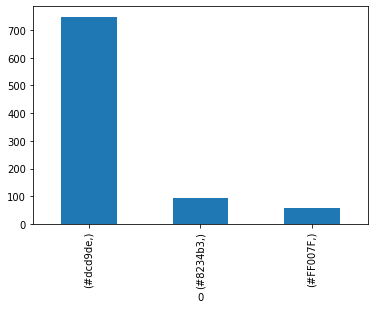

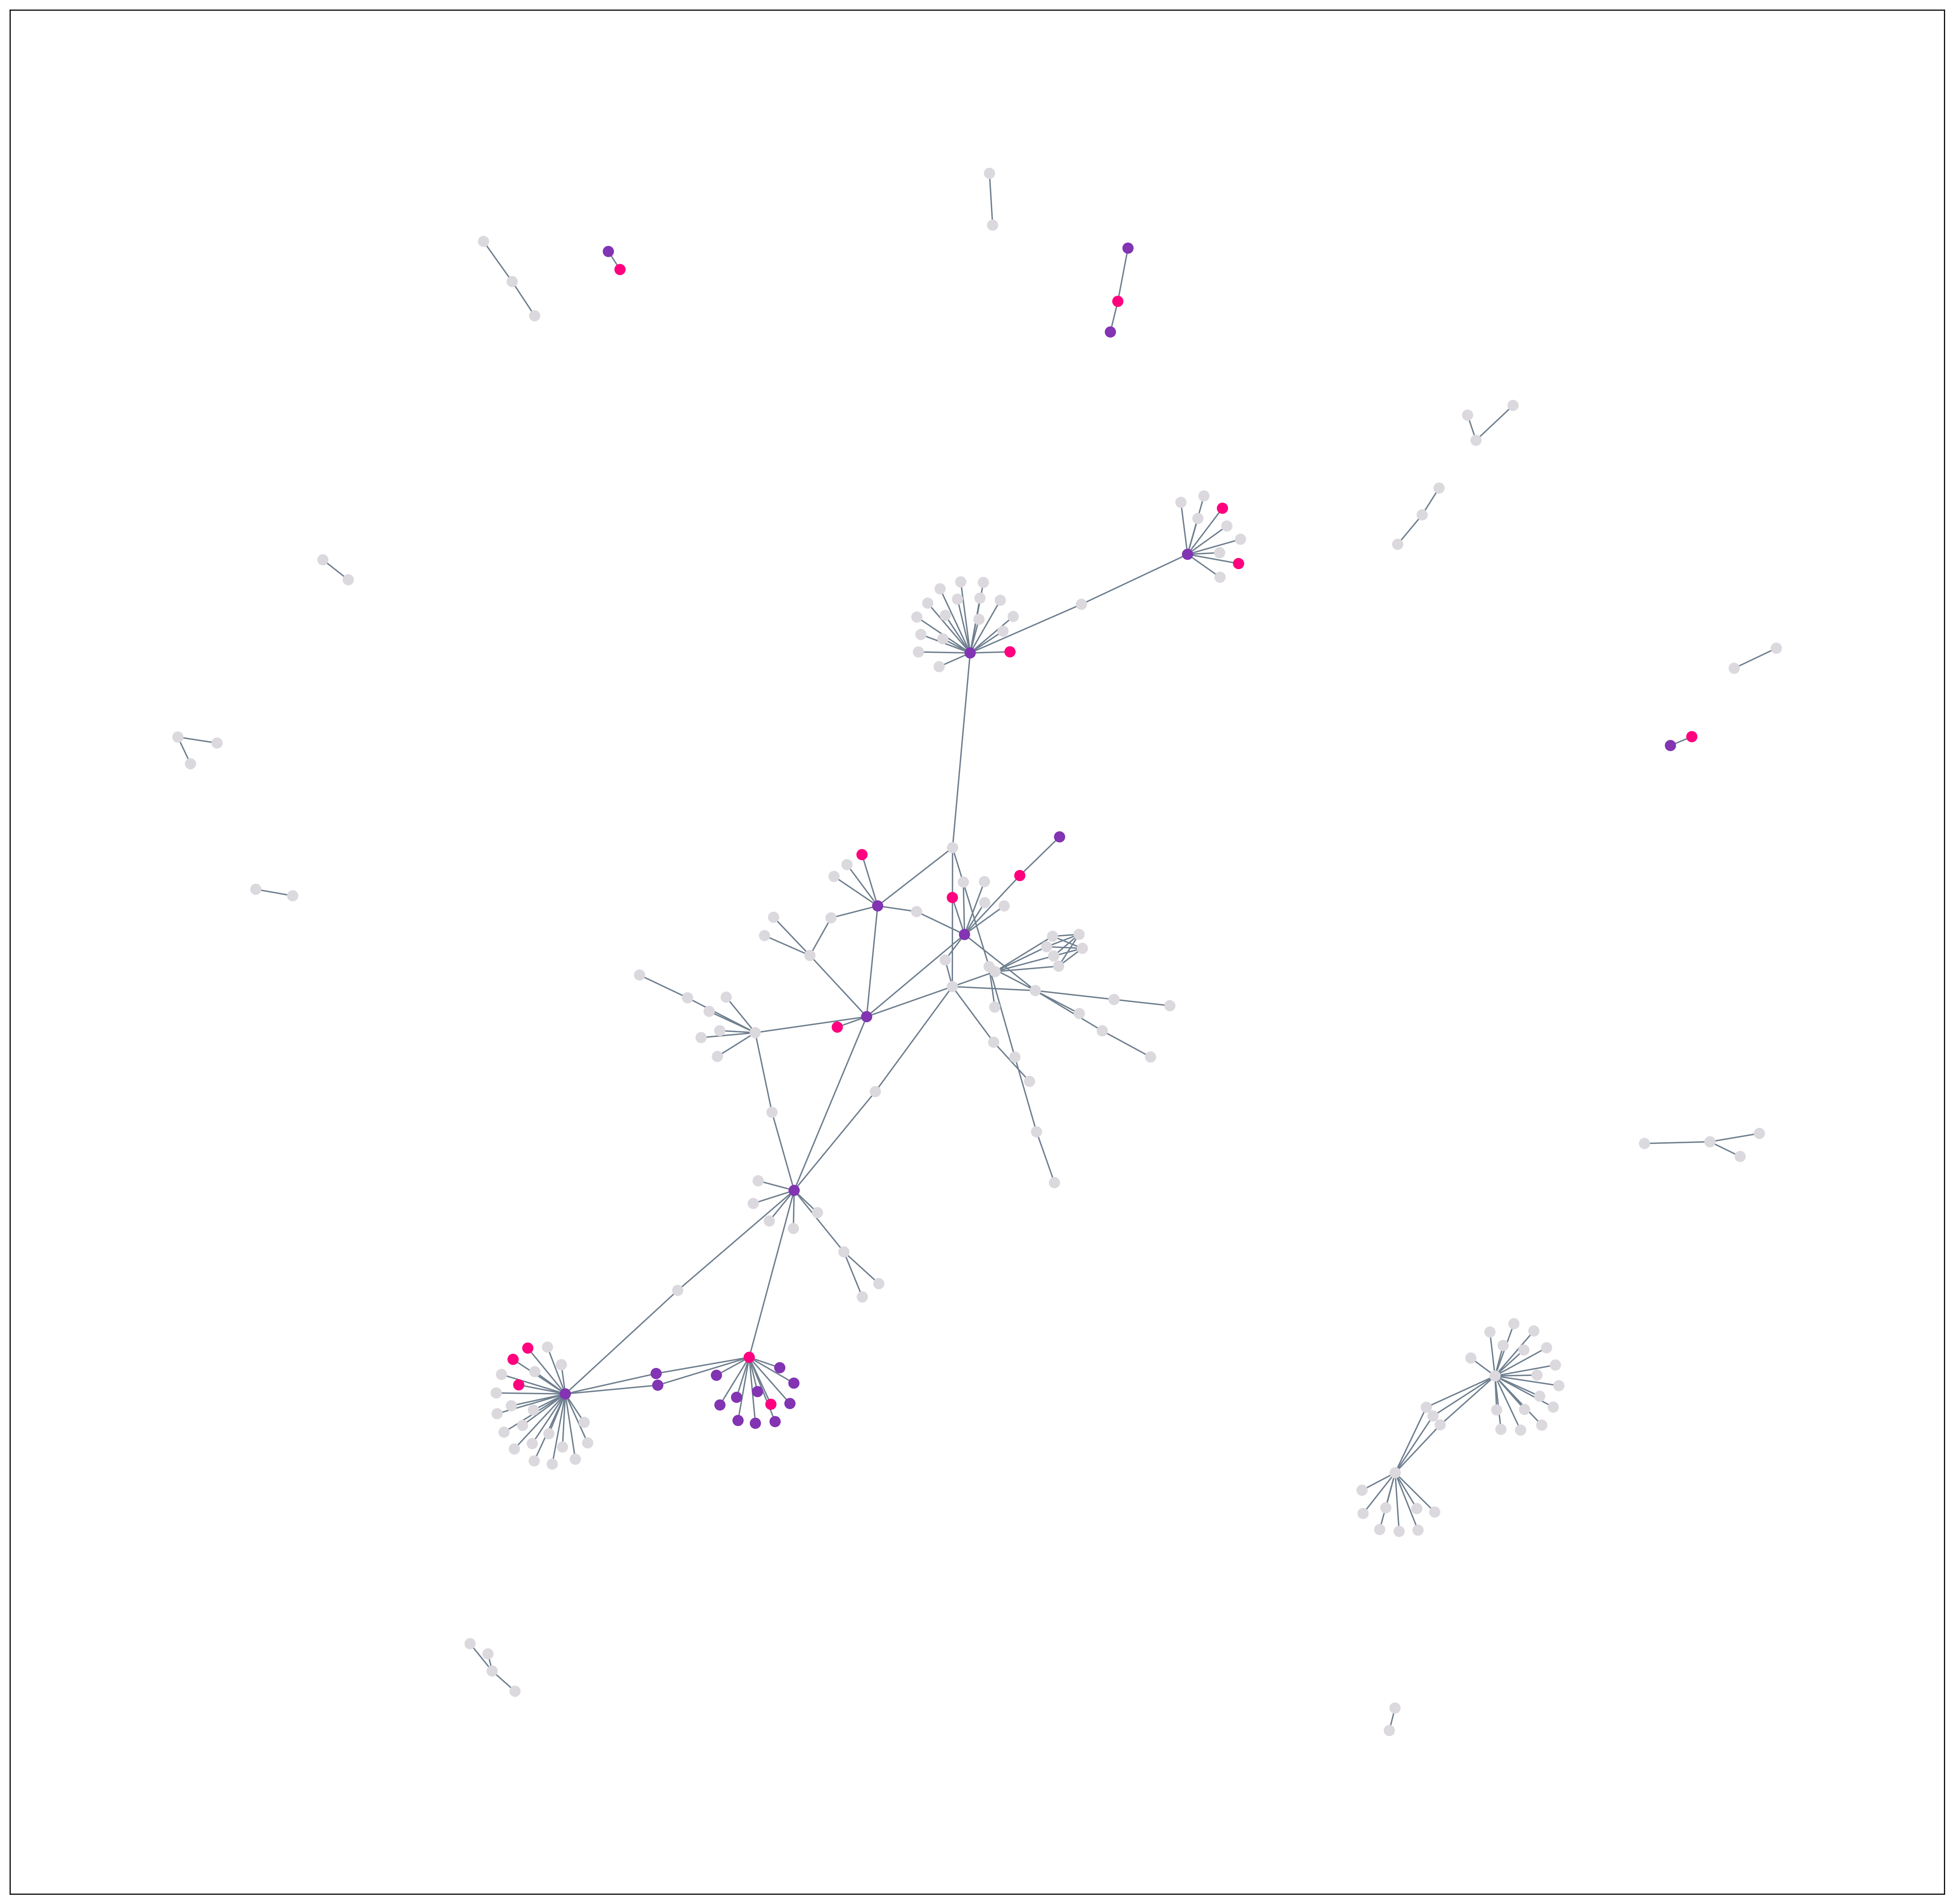

              0
ABL1    #dcd9de
ACE     #dcd9de
ADAM23  #dcd9de
ADCY2   #8234b3
ADRA2A  #dcd9de
...         ...
VEGFA   #FF007F
VIP     #dcd9de
VLDLR   #8234b3
VRK2    #dcd9de
WNT3A   #dcd9de

[195 rows x 1 columns]


ValueError: Shape of passed values is (2, 1), indices imply (2, 2)

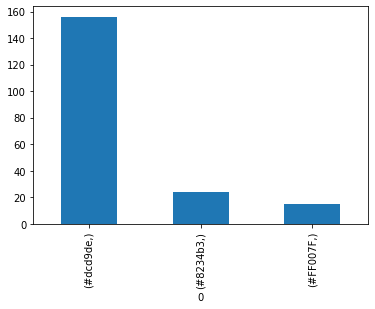

In [101]:
list_longest = []
for res in range(0,2):
    db = op.interactions.import_intercell_network(transmitter_params = {"categories":"ligand"}, receiver_params = {"categories": "receptor"})
    print(np.shape(db))
    db = db[np.logical_not(db['genesymbol_intercell_source'].str.startswith('HLA'))]
    db = db[np.logical_not(db['genesymbol_intercell_target'].str.startswith('HLA'))]
    db = db[~db['genesymbol_intercell_target'].astype(str).str.startswith('COMPLEX')]
    db = db[~db['genesymbol_intercell_source'].astype(str).str.startswith('COMPLEX')]
    print(np.shape(db))
    print(path[res].split('_')[2])
    tgts_all = pd.read_csv(path[res])
    tgts_all['gene']=tgts_all['genes']
    tgts = tgts_all.drop(columns=['genes']).set_index(['gene'])

    source, percSrc, targets, percTgt, sum = ml.lr.find_hits(tgts, db)

    LRs = db[['genesymbol_intercell_source','genesymbol_intercell_target']][(db['genesymbol_intercell_source'].isin(list(sum.gene))) | (db['genesymbol_intercell_target'].isin(list(sum.gene)))]
    unique_genes = np.unique(list(LRs['genesymbol_intercell_source'])+list(LRs['genesymbol_intercell_target']))
    #res_DEGs_list = list(set(unique_genes) & set(DEGs_list))
    #DE_LRs = db[['genesymbol_intercell_source','genesymbol_intercell_target']][(db['genesymbol_intercell_source'].isin(list(res_DEGs_list))) | (db['genesymbol_intercell_target'].isin(list(res_DEGs_list)))]
    # Take all affected LRs 
    #all_LRs = np.unique(list(DE_LRs['genesymbol_intercell_source'])+list(DE_LRs['genesymbol_intercell_target']))
    #interactors = list(set(all_LRs) - set(res_DEGs_list))

    #comparison['number of LRs'].iloc[res] = len(unique_genes)

    # Adjacency matrix with entire network across all diseases
    adj_LRs = pd.DataFrame(np.zeros(shape=(len(unique_genes), len(unique_genes))), index = unique_genes, columns = unique_genes)

    for n in range (0, np.shape(LRs)[0]):
        adj_LRs.iloc[adj_LRs.index.get_loc(LRs.iloc[n]['genesymbol_intercell_source']), adj_LRs.columns.get_loc(LRs.iloc[n]['genesymbol_intercell_target'])] += 1

    #Number of cell-cell interactions ligands of interest are involved in
    print(adj_LRs.sum(axis = 0).sort_values(ascending=False)[adj_LRs.sum(axis = 0).sort_values(ascending=False).index.isin(list(tgts.index))])

    #Number of cell-cell interactions receptors of interest are involved in
    adj_LRs.sum(axis = 1).sort_values(ascending=False)[adj_LRs.sum(axis = 1).sort_values(ascending=False).index.isin(list(tgts.index))]

    # Overview of LR network and calculating rank of importance with PageRank

    H = nx.from_pandas_adjacency(adj_LRs)
    comms = ml.network.louvain_communities(H, seed = 123, resolution = 0.01)

    # Check which is the largest network and save % of total LRs in network
    for l in range(0,len(comms)):
        this = len(comms[l])
                    
        if (l == 0):
            longest = this
            cluster = comms[l]
        elif (this > longest):
            longest = this
            cluster = comms[l]
                    
    list_longest.append(longest/len(H))

    # Define your specific list of nodes
    specific_nodes = DEGs_list  # Replace with your specific nodes

    # Find all directly connected nodes
    connected_nodes = set()
    for node in specific_nodes:
        if node in H:
            connected_nodes.update(H.neighbors(node))

    # Create a colour mapping for the nodes
    node_colours = []
    for node in H.nodes:
        if node in DEGs_list:
            node_colours.append('#FF007F')
        elif node in connected_nodes:
            node_colours.append('#8234b3')
        else:
            node_colours.append('#dcd9de')

    plt.figure(figsize=(25, 25), dpi=300)

    # Define positions using spring_layout
    pos = nx.spring_layout(H)

    # Draw the nodes with the custom colours
    nx.draw_networkx_nodes(H, pos, node_color=node_colours, node_size=50)

    # Draw the edges
    nx.draw_networkx_edges(H, pos, edge_color='slategrey')

    # Save the plot
    plt.savefig("plots/08-visualise_DEGs/network_visualisation_DEGs_%s.png" % path[res].split('_')[2].split('.csv')[0], dpi=300)
    plt.show()
    print(pd.DataFrame(node_colours, index = list(H.nodes)))
    pd.DataFrame(node_colours, index = list(H.nodes)).value_counts().plot.bar()
pd.DataFrame(np.asarray(list_longest).reshape(-1,1), columns=df.columns)

Possible subsequent tests: 
Calculate spread of DEGs
Dentrality of DEGs

Alternatively I could make it  biological question - Of the connecting nodes, which diseases do they relate to? e.g. are AD genes likely to be affected? 